<font size="+1">A Bayesian Approach to Final Adjusted Values</font> <br><br>

In this workbook we are going to estimate final adjusted values (FAVs) for a list of compounds using a couple of different methods. FAVs are physical-chemical property values adjusted for thermodynamic consistency, as each of the properties can be expressed as a combination of the other properties (Cole and Mackay, 2000; Beyer et al., 2002). The properties of interest are as follows:
<font size="+1">Solubilities</font> <br><br>
Subcooled liquid vapour pressure (PL/Pa) - converted to subcooled liquid air solubility (SAL/mol m-3) as SAL = PL/RT (Cole & Mackay, 2000)
Subcooled liquid water solubilty (SWL/mol m-3)
Subcooled liquid octanol solubility (SOL/mol m-3)
<font size="+1">Dimensionless Partition Coefficients</font> <br><br>
Octanol/Water partition coefficient (KOW)
Octanol/Air partition coefficient (KOA)
Air/Water partition coefficent (KAW) - can be derived from Henry's law constant (H/Pa m3 mol-1) as KAW = H/RT

The properties are related as:<br>
logKaw = logSa - logSw (1)<br>
Log Koa = LogSo - logSa (2)<br>
LogKow = logSow - logSwo (3) (note that this is dry octanol Kow)<br>
LogSo/Sw = logSo-logSw (4)<br>
From this, we can derive a set of equation which gives the "misclosure error" (w) between the data points, where w is 0 in a completely consistent data set, such as our FAVs, as (Schenker et al., 2005):<br>
logKaw - logKow + logKoa = w0 (5)<br>
then we can adjust these values with an adjustment, vi, where (if the relative uncertainty between the values is equal) 
w0 = v1-v2+v3 (6) (for the equation above) such that:<br>
FAVKaw = logKaw-v1 (7)<br>
FAVKow = logKow-v2 (8)<br>
FAVKoa = logKoa-v3 (9)<br>
This system can be extended so that instead of a single equation (5) we have a system of equations, based on (1)-(4) as:<br>
log(Sa) - log(Sw) -log(Kaw) = w1 (10)<br>
log(Sa) - log(So) + log(Koa) = w2 (11)<br>
log(Sw) - log(So) + log(Kow) = w3(12) (note that this is dry octanol Kow)<br>

The temperature dependence of these properties(K or S) can be estimated over a small temperature gradient using a modified Van't Hoff equation as ln(K/S(T2)) = ln(K/S(T1))- dU/R(1/T2-1/T1), where dU is the internal energy of phase change. All values entered into the model should be at 25°C. This paper has used properties corrected from within 5°C of that value (20 - 30 °C, inclusive) to derive the LDVs, unless otherwise noted. 

These internal energy values can also be adjusted, using a similar set of equations to the above (Beyer et al., 2002):<br>
dUaw - dUow +dUoa = w4 (13a) or equivalently dUa - dUw -dUow +dUoa = w4 (13b).<br>


Here, we are going to use a Bayesian approach for the adjustement. This will estimate the probability distribution of each property value using Bayes' theorem.

The FAV adjustment problem is amenable to a simple Bayesian approach. The Bayesian approach has the advantage of taking an "uncertainty first" view of data and of generating a probability distribution for every measured value. Uncertainty in physico-chemical properties is often one of the most important sources of uncertainty in a chemical fate model, but this uncertainty can be difficult to quantify as measured and modelled values can diverge significantly, but the reported uncertainty for each is typically very small, and it can be hard to tell how well we know what we think we know. The Bayesian approach is ready-made for robust uncertainty analysis, as the probability distributions required for a Monte Carlo analysis are the outputs of a Bayesian model.

This notebook will walk through this approach, providing an open-source tool for anyone familiar with basic Python. This notebook will use the data from Rodgers et al. (2020), which is included with this notebook on Github. Users can replace this with their own data, as long as it follows the same format (or feel free to change the code!). We will be making two sets of FAVs here - FAVLs, which are based only on literature measured values, and FAVRs, which supplement the literature measured values with in-silico property estimations where measurements are unavailable, to provide a complete set of recommended values for each compound. 

The layout of this notebook will be as follows:
1. Estimate FAVLs for the internal energies using only literature measured values as priors
    1a. Check consistency, assess bias of adjustments
    1b. Evaluate in-silico estimates vs FAVLs & LDVs (where necessary) to select best in-silico estimations for each property by compound class
2. Estimate FAVRs for the internal energies using LDVs & best in-silico values as priors
    2a. Check consistency, assess bias of adjustments
    2b. Use FAVRs to adjust the partition coefficient and solubility measurements to 298.15 K (not shown, done in Excel)
3. Estimate FAVLs for the partition coefficients & solubilities using only literature measured values as priors
    3a. Check consistency, assess bias of adjustments
    3b. Evaluate in-silico estimates vs FAVLs & LDVs (where necessary) to select best in-silico estimations for each property by compound class
4. Estimate FAVRs for the partition coefficients & solubilites using LDVs & best in-silico values as priors
    4a. Check consistency, assess bias of adjustments

In [1]:
#IF you are coming from "part 1" of this program, make sure you have updated the partition coefficients
#and solubilities using the FAVR dUs generated in the previous step.

#First, we need to load the data and necessary packages.
#Then, we will combine the LDV and the associated uncertainty into a single variable with a mean and a standard deviation
#To perform the inital uncertainty propagation we will use standard uncertainty propagation in a package "uncertainties"
#(source: https://uncertainties-python-package.readthedocs.io/en/latest/)
import uncertainties
from uncertainties import ufloat
from uncertainties import unumpy
import pandas as pd
import numpy as np
import math
import pymc3 as pm
import matplotlib.pyplot as plt
import pdb
import pymc3 as pm
import arviz as az
from datetime import datetime
#Load Data
LDV = pd.read_excel('LDV_Data.xlsx', index_col = 2)
#Now, we are going to make each of our LDVs into uncertain variables with the uncertaintites through this package.
#We will make a separate dataframe for the uncertain values
startcol = 3 #First column with LDVs in it. Column order should have all data identifiers first, followed by LDVs,
#their standard deviations and then the number of literature values for each property
uLDV = pd.DataFrame(index = LDV.index)
#Name the columns
colnames =['dVAPH','dWU','dOU','dOAU','dAWU','dOWU','LogKOA','LogKOW','LogKAW','LogPL','LogSW','LogSO','dfusS','Tm']
i = 0
#Loop through the columns to get the values, skipping the columns with standard deviations & number of lit values
for idx,cols in enumerate(LDV.columns[startcol:]):
    if idx/3 != math.ceil(idx/3):
        pass
    else:
        colname = colnames[i]
        #Add the uncertain values. Format is (nominal value, standard deviation)
        uLDV.loc[:,colname] = unumpy.uarray(LDV.loc[:,cols],LDV.iloc[:,idx+startcol+1])#adding 1 to get to first SD value
        i+=1
#Run again for the number of values - this puts the number of values columns at the end rather than interspersed.
i = 0
for idx,cols in enumerate(LDV.columns[startcol:]):
    if idx/3 != math.ceil(idx/3):
        pass
    else:
        #The number of values will be labelled colname_NumVals e.g. 'LogKOW_NumVals'
        colname = colnames[i]+str('_NumVals') 
        uLDV.loc[:,colname] = LDV.iloc[:,idx+startcol+2] #Column where number of values is stored
        i+=1
#Next, we will convert our vapour pressures to a solubility: Sa = VP/RT
R = 8.314 #J/molK
T = 298.15 #K
uLDV.loc[:,'LogSA'] = unumpy.log10(10**(uLDV.LogPL)/(R*T))#Convert to mol/m³
uLDV.loc[uLDV.LogPL==0,'LogSA'] = np.nan #Convert zeros to nan\
#Here we will also convert the wet octanol partition coefficient to dry so that we are all on the same page
#Using the relationships from Beyer (2002)
LDV.loc[:,'LogKOWd'] = np.nan#initialize
mask = uLDV.loc[:,'LogKOW']<=4
uLDV.loc[mask,'LogKOWd'] = uLDV.LogKOW - 0.117 #If Kow<=4
uLDV.loc[mask==False,'LogKOWd'] = 1.35*uLDV.LogKOW - 1.58
uLDV.loc[uLDV.LogKOW==0,'LogKOWd'] = np.nan #Convert zeros to nan\
#convert to internal energy of phase change (dU) rather than enthalpies (dH) (see Goss 1996 DOI 10.1021/es950508f) using rel.
#found by Beyer et al. (2002) for PCBs, namely dAU = dvapH - 2,391 J/mol. Like Beyer, we will assume that all enthalpies of
#phase change in the water phase are actually internal energies, as they were measured volumetrically.
uLDV.loc[:,'dAU'] = uLDV.dVAPH - 2391/1000
uLDV.loc[uLDV.dVAPH==0,'dAU'] = np.nan #Convert zeros to nan\
uLDV = uLDV.replace(0,np.nan) #Convert all zeros to nans for the next part
#Now. lets make the dataframe where we will store our FAVs once they have been estimated! 
FAVs = pd.DataFrame(index = uLDV.index)
#Need to initialize with a value or it doesn't like the ufloat objects
FAVs.loc[:,'Class'] = LDV.loc[:,'Class']
#Partition coefficients & solubilites (KS)
FAVs.loc[:,'LogSA'] = ufloat(0,0)
FAVs.loc[:,'LogSW'] = ufloat(0,0)
FAVs.loc[:,'LogSO'] = ufloat(0,0)
FAVs.loc[:,'LogKAW'] = ufloat(0,0)
FAVs.loc[:,'LogKOW'] = ufloat(0,0)
FAVs.loc[:,'LogKOA'] = ufloat(0,0)
#Next, determine what properties are absent from each system
#KS Absent
KSabsent = unumpy.isnan([uLDV.loc[:,'LogSA'],uLDV.loc[:,'LogSW']\
            ,uLDV.loc[:,'LogSO'],uLDV.loc[:,'LogKAW'],\
            uLDV.loc[:,'LogKOW'],uLDV.loc[:,'LogKOA']]).T
uLDV.loc[:,'SA_absent'] = KSabsent[:,0]
uLDV.loc[:,'SW_absent'] = KSabsent[:,1]
uLDV.loc[:,'SO_absent'] = KSabsent[:,2]
uLDV.loc[:,'KAW_absent'] = KSabsent[:,3]
uLDV.loc[:,'KOW_absent'] = KSabsent[:,4]
uLDV.loc[:,'KOA_absent'] = KSabsent[:,5]
uLDV.loc[:,'nKSs_absent'] = uLDV.loc[:,'SA_absent':'KOA_absent'].sum(axis=1)
#KS misclosure errors for all compounds, nans where not enough info is present.
uLDV.loc[:,'w_Ks'] = uLDV.loc[:,'LogKAW']-uLDV.loc[:,'LogKOW']+uLDV.loc[:,'LogKOA']
#4 Compound misclosures
uLDV.loc[:,'w4']= uLDV.loc[:,'LogSA']-uLDV.loc[:,'LogSW']-uLDV.loc[:,'LogKOW']+uLDV.loc[:,'LogKOA']
uLDV.loc[:,'w5']= (uLDV.loc[:,'LogSA'] - uLDV.loc[:,'LogSW'] - uLDV.loc[:,'LogKOWd']+ uLDV.loc[:,'LogKOA'])
#Equations 10-12
uLDV.loc[:,'w_KAW']= uLDV.loc[:,'LogSA']-uLDV.loc[:,'LogSW']-uLDV.loc[:,'LogKAW']
uLDV.loc[:,'w_KOW']= uLDV.loc[:,'LogSW']-uLDV.loc[:,'LogSO']+uLDV.loc[:,'LogKOW']
uLDV.loc[:,'w_KOA']= uLDV.loc[:,'LogSA']-uLDV.loc[:,'LogSO']+uLDV.loc[:,'LogKOA']
#Set nans where appropriate
arr = uLDV.loc[:,'w_Ks':'w_KOA']
arr = np.ma.filled(np.ma.masked_where(unumpy.isnan(arr),arr),np.nan)
uLDV.loc[:,'w_Ks':'w_KOA'] = arr

D:\Anaconda3\lib\site-packages\distributed\config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


First, we will calculate the literature-only FAVs (FAVLs) for the partition coefficients and solubilites

In [2]:
#Now, in the dataset from our paper no compound has all internal energies. So, lets look at what compounds 
#are missing only a single internal energy
numUs_absent = 1
uLDV.loc[uLDV.nUs_absent==numUs_absent,'dAU_absent':'dOAU_absent']
#Just B[a}P - and it is missing dUaw

,dAU_absent,dWU_absent,dOU_absent,dAWU_absent,dOWU_absent,dOAU_absent
Compound Name,,,,,,
benzo[a]pyrene,False,False,False,True,False,False


In [4]:
#Now, we will set up our Bayesian estimation and solve! This one is for compounds that have all internal energies 
#or that are missing only one. If they are missing a single property, we will use a uniform distribution to replace
#that property, allowing us to estimate the single missing property.

#In the example dataset for B[a}P we are only missing one property, dUaw. 
#This will solve the following set of equations:
#dUa - dUW - dUAW = 0 [1 -1 -1 0 0] = 0
#dUw - dUo + dUOW = 0 [0 1 -1 0 1 0] = 0
#dUa - dUo + dUoa = 0 [1 0 -1 0 0 1] = 0
#Set up the matrix, order is: dUa, dUw, dUo, dUaw, dUow, dUoa
enthbasemat = np.array([[1, -1, 0, -1, 0, 0] ,[0, 1, -1, 0, 1, 0],[1, 0, -1, 0, 0, 1]])  
#X will be the system equation (enthbasemat), y is the misclosure error - which is 0 in this case
X = enthbasemat
y = 0
#Then, we set up our Bayesian model with the measurements as priors for the model regression parameters. 
#This uses our knowledge of the compounds, while the model tells us whether this works.
#Define the number of values missing, which will set our compound list. You can also override this.
numUs_absent = 1
comps = uLDV.loc[uLDV.nUs_absent==numUs_absent].index
#Then, we loop through the compounds for each. 
for comp in comps:
    #We are going to adjust the priors of our system based on the misclosure error, as an estimate of the 
    #certainty of the system. Basically, we are going to take the largest misclosure error and divide it by the
    #number of parameters in each eqauation and use that as our baseline minimum standard deviation.
    #Then, we are going to take that value and divide it by the number of literature values that were used to
    #determine a property, with the reasoning that we are more sure about our prior unertainty (the lit SD) with
    #more measurements added together
    #Define the cases for the base_standard deviation based on the properties that are absent
    if uLDV.loc[comp,'nUs_absent']==0:
        base_sd = max([abs(uLDV.loc[comp,'dAU'] - uLDV.loc[comp,'dWU'] - uLDV.loc[comp,'dAWU']).n,\
                    abs(uLDV.loc[comp,'dWU'] - uLDV.loc[comp,'dOU'] + uLDV.loc[comp,'dOWU']).n,\
                    abs(uLDV.loc[comp,'dAU'] - uLDV.loc[comp,'dOU'] + uLDV.loc[comp,'dOAU']).n])
    elif (uLDV.loc[comp,'nUs_absent']==1) & (uLDV.loc[comp,'dOU_absent']==True): #dUa - dUw - dUaw; dUaw - dUow + dUoa
        base_sd = max([abs(uLDV.loc[comp,'dAU'] - uLDV.loc[comp,'dWU'] - uLDV.loc[comp,'dAWU']).n,\
                    abs(uLDV.loc[comp,'dAWU'] - uLDV.loc[comp,'dOWU'] + uLDV.loc[comp,'dOAU']).n])
    elif (uLDV.loc[comp,'nUs_absent']==1) & (uLDV.loc[comp,'dOWU_absent']==True): #dUa - dUw - dUaw; dUaw - dUo + dUw + dUoa
        base_sd = max([abs(uLDV.loc[comp,'dAU'] - uLDV.loc[comp,'dWU'] - uLDV.loc[comp,'dAWU']).n,\
                    abs(uLDV.loc[comp,'dAWU'] - uLDV.loc[comp,'dOU']+uLDV.loc[comp,'dWU'] + uLDV.loc[comp,'dOAU']).n])
    elif (uLDV.loc[comp,'nUs_absent']==1) & (uLDV.loc[comp,'dAWU_absent']==True): #dUa - dUo + dUoa; dUa - dUw -dUow + dUoa
        base_sd = max([abs(uLDV.loc[comp,'dAU'] - uLDV.loc[comp,'dOU'] + uLDV.loc[comp,'dOAU']).n,\
                    abs(uLDV.loc[comp,'dAU'] - uLDV.loc[comp,'dWU']-uLDV.loc[comp,'dOWU'] + uLDV.loc[comp,'dOAU']).n])
    else: 
        brkpoint = 1/0 #Break if not one of the above
    base_sd = base_sd/3 #the divisor is the number of parameters in each equation
    #Define the model name.
    enth6_model = pm.Model()
    beta = [0,0,0,0,0,0]
    with enth6_model:
        #Define priors
        sigma = pm.HalfNormal('sigma', 0.1, testval=0.1) #Acceptable FAV misclosure error prior
        #For the phys-chem properties, we have some choices of priors depending on our confidence in the data.
        #For our defaults we can use normal distributions, with the mean as the central tendency and the standard
        #deviation of the LDVs as the standard deviation
        #The unknown parameter is given a uniform distribution that encompasses the possible range of values    
        try: #Test to see if which parameter is gone, parameterize accordingly
            beta[0] = pm.Normal('dUA', mu = uLDV.loc[comp,'dAU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dVAPH_NumVals'],uLDV.loc[comp,'dAU'].s))
        except AttributeError:#Wide prior, needs to capture range
            beta[0] = pm.Uniform('dUA', lower = 0, upper = 200)

        try:
            beta[1] = pm.Normal('dUW', mu = uLDV.loc[comp,'dWU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dWU_NumVals'],uLDV.loc[comp,'dWU'].s))
        except AttributeError:#Wide prior, needs to capture range
            beta[1] = pm.Uniform('dUW', lower = -100, upper = 100)

        try:
            beta[2] = pm.Normal('dUO', mu = uLDV.loc[comp,'dOU'].n,\
                                sigma=max(base_sd/uLDV.loc[comp,'dOU_NumVals'],uLDV.loc[comp,'dOU'].s))
        except AttributeError:#Wide prior, needs to capture range
            beta[2] = pm.Uniform('dUO', lower = -100, upper = 100)

        try:
            beta[3] = pm.Normal('dUAW', mu = uLDV.loc[comp,'dAWU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dAWU_NumVals'],uLDV.loc[comp,'dAWU'].s))
        except AttributeError:#Wide prior, needs to capture range 
            beta[3] = pm.Uniform('dUAW', lower = 0, upper = 150)

        try:
            beta[4] = pm.Normal('dUOW', mu = uLDV.loc[comp,'dOWU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dOWU_NumVals'],uLDV.loc[comp,'dOWU'].s))
        except AttributeError:#Wide prior, needs to capture range
            beta[4] = pm.Uniform('dUOW', lower = -100, upper = 100)

        try:
            beta[5] = pm.Normal('dUOA', mu = uLDV.loc[comp,'dOAU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dOAU_NumVals'],uLDV.loc[comp,'dOAU'].s))
        except AttributeError: #Wide prior, needs to capture range
            beta[5] = pm.Uniform('dUOA', lower = -150, upper = 0)

        epsilon = np.dot(X,beta) #This gives us the misclosure error for each of the three equations
        #The model tries to fit to an observation, in this case that the misclosure should be 0.
        #We add the sum of squared errors to ensure that we don't over-fit to one equation.=
        mu = np.sum(epsilon**2)
        #For the likelihood distribution we will use a Student's T regression, fatter tails 
        Y_obs = pm.StudentT('Y_obs',nu = len(beta)-1, mu=mu, sigma=sigma, observed=y)
        #Then, we run the model! This has the form (number of samples, number of tunes, number of chains, number of cores
        #target_accept probability, max_treedepth), for more info on these see pymc3 documentation
        #To define the model without running, comment out everything below here
        '''
        enth6_trace = pm.sample(15000, tune=30000,chains = 5, cores = 10, target_accept = 0.95, max_treedepth = 15)#, step=step)
        #Then, save the traces - this tutorial uses a folder called "pickles" and saves with the compound 
        #name and date/time. Remove square brackets from comp. name - in the example dataset just the PAHs
        if comp == "benzo[k]fluoranthene": #Error from the square brackets in loading files
            comp = "benzokfluoranthene"
        elif comp == "benzo[a]pyrene":
            comp = "benzoapyrene"
        savename = str('Pickles/'+ comp+"_dUs_"+datetime.now().strftime("%m%d_%H%M"))
        pm.save_trace(enth6_trace,directory = savename,overwrite=True)
        '''

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001939F86DDD8>,
      dtype=object)

Text(0.5, 0.98, 'benzo[a]pyrene')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dUA,107.216,3.427,100.628,113.515,0.021,0.015,26813.0,26813.0,26829.0,32586.0,1.0
dUW,31.269,4.837,22.211,40.332,0.030,0.022,25432.0,25242.0,25438.0,29323.0,1.0
dUO,6.638,2.553,1.817,11.428,0.014,0.010,31036.0,30908.0,31053.0,32029.0,1.0
dUOW,-24.634,4.459,-33.007,-16.153,0.028,0.020,26070.0,25857.0,26046.0,30648.0,1.0
dUOA,-100.583,2.512,-105.253,-95.849,0.014,0.010,30435.0,30435.0,30434.0,33043.0,1.0
sigma,0.106,0.063,0.006,0.217,0.000,0.000,22627.0,22627.0,11938.0,7322.0,1.0
dUAW,75.947,5.106,66.496,85.724,0.033,0.023,24024.0,24009.0,24024.0,29304.0,1.0


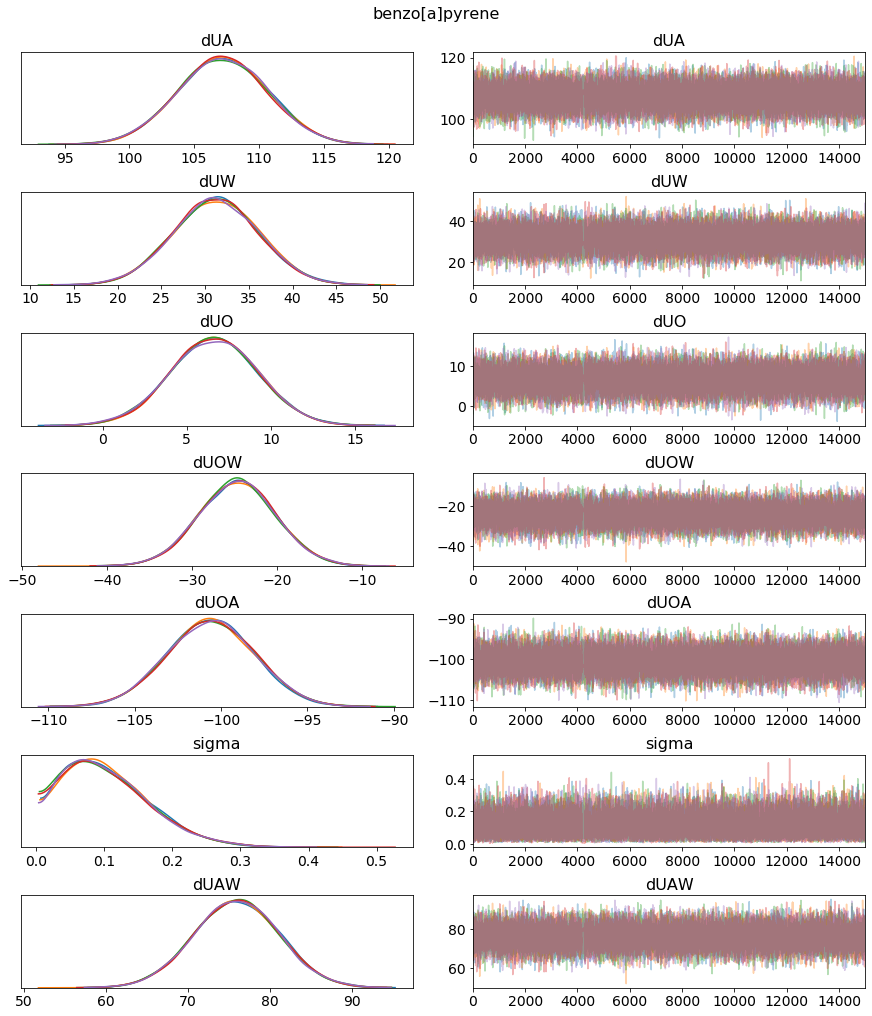

In [9]:
#Next, we look at the trace plots and the number of effective samples to determine if the solution converged
#These first lines sets jupyter so that the traceplots and summary tables will all be displayed together
import os
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Define the directory where you have saved the traces.
directory = "Pickles/_FAV_Traces/dUs/5_param/"
#If you want to look at specific compoundd use the following two lines of code, otherwise it loops
#through the entire folder
#filenames = ['benzoapyrene_dUs_1125_1740']
#for filename in filenames:
#Loop through the folder
for filename in os.listdir(directory):
    #Define the compound from the filename, correct the square bracket error on the PAHs
    comp = filename[0:filename.find("_")]
    if comp == "benzokfluoranthene": #Error from the square brackets in loading files
        comp = "benzo[k]fluoranthene"
    elif comp == "benzoapyrene":
        comp = "benzo[a]pyrene"
    #Then, load the traceplot. You must have the correct model defined, unfortunately - so you need to
    #set-up the pymc3 model for each missing property.
    loaded6trace = pm.load_trace(directory = directory+filename, model = enth6_model);
    #The traceplot displays a graph of the poseteriors for each chain and the traceplots
    pm.traceplot(loaded6trace);
    #To give the figure a title need to obtain figure name and then define title
    fig = plt.gcf();
    fig.suptitle(comp, fontsize=16)
    #pm.summary displays 
    pm.summary(loaded6trace)
    #Put the finished FAVs into our output dataframe
    FAVs.loc[comp,'dUA'] = ufloat(loaded6trace['dUA'].mean(),loaded6trace['dUA'].std())
    FAVs.loc[comp,'dUW'] = ufloat(loaded6trace['dUW'].mean(),loaded6trace['dUW'].std())
    FAVs.loc[comp,'dUO'] = ufloat(loaded6trace['dUO'].mean(),loaded6trace['dUO'].std())
    FAVs.loc[comp,'dUAW'] = ufloat(loaded6trace['dUAW'].mean(),loaded6trace['dUAW'].std())
    FAVs.loc[comp,'dUOW'] = ufloat(loaded6trace['dUOW'].mean(),loaded6trace['dUOW'].std())
    FAVs.loc[comp,'dUOA'] = ufloat(loaded6trace['dUOA'].mean(),loaded6trace['dUOA'].std())
#To assess this, as described in Rodgers et al (2020), look at ess_bulk - if it is >5,000, the system has
#almost certainly converged. If ess_bulk is <5,000, look at the figure - if the chains do not overlap
#you may need to rerun with a higher number of tuning steps or higher target_accept. For our tutorial it
#should work fine.

In [10]:
#Great! Now lets look at compounds with two properties missing. 
numUs_absent = 2
uLDV.loc[uLDV.nUs_absent==numUs_absent,'dAU_absent':'dOAU_absent']
#There are quite a few this time. All except for p,p'-DDE and o,p'-DDT are missing the dUo and dUaw,
#those two are missing dUaw and dUow - we will deal with them later.

,dAU_absent,dWU_absent,dOU_absent,dAWU_absent,dOWU_absent,dOAU_absent
Compound Name,,,,,,
Musk Ambrette,False,False,True,True,False,False
Phantolide,False,False,True,True,False,False
Traseolide,False,False,True,True,False,False
Galaxolide 1,False,False,True,True,False,False
Musk Tibetene,False,False,True,True,False,False
"p,p'- DDE",False,False,False,True,True,False
"o,p'-DDT",False,False,False,True,True,False
BDE-47,False,False,True,True,False,False
PCB-209,False,False,True,True,False,False


In [18]:
#Now we are going to loop through the compounds with missing dUo and dUaw. For these, we are going to run
#the five-parameter model with a uniform prior for the missing value of dUaw, in order to estimate it
#directly and get the MCMC uncertainty. 
#This gives us the following equations:
#dUa*(1)+ dUw *(-1) + dUAW *(-1)= 0 [1 -1 -1 0 0] = 0
#dUAW*(1)+ dUOW *(-1) + dUOA *(1)= 0 [0 0 1 -1 1] = 0
#X will be the system equation (enthbasemat), y is the misclosure error - which is 0 in this case
enthbasemat = np.array([[1, -1, -1, 0, 0],[0, 0, 1, -1, 1]])  #Order is: dUa, dUw, dUaw, dUow, dUoa
X = enthbasemat
y = 0
#Then, we set up our Bayesian model with the measurements as priors for the model regression parameters. 
#This uses our knowledge of the compounds, while the model tells us whether this works.
#Define the mask to set our compound list. You can also override this.
numUs_absent = 2
mask = (uLDV.nUs_absent==numUs_absent)&(uLDV.dAWU_absent==True)&(uLDV.dOU_absent==True)
comps = uLDV[mask].index
#Override to run a specific compound
#comps = ['Musk Ambrette']
#Then, we loop through the compounds for each. 
for comp in comps:
    #We are going to adjust the priors of our system based on the misclosure error, as an estimate of the 
    #certainty of the system. Basically, we are going to take the largest misclosure error and divide it by the
    #number of parameters in each eqauation and use that as our baseline minimum standard deviation.
    #Then, we are going to take that value and divide it by the number of literature values that were used to
    #determine a property, with the reasoning that we are more sure about our prior unertainty (the lit SD) with
    #more measurements added together
    #Define the cases for the base_standard deviation based on the properties that are absent
    base_sd = uLDV.loc[comp,'dAU']- uLDV.loc[comp,'dWU']-uLDV.loc[comp,'dOWU']+uLDV.loc[comp,'dOAU']
    base_sd = base_sd.n/4 #the divisor is the number of parameters in each equation
    #Define the model name.
    enth5_model = pm.Model()
    beta = [0,0,0,0,0]
    #pdb.set_trace()
    with enth5_model:
        #Define priors
        sigma = pm.HalfNormal('sigma', 0.1, testval=0.1) #Acceptable FAV misclosure error prior
        #For the phys-chem properties, we have some choices of priors depending on our confidence in the data.
        #For our defaults we can use normal distributions, with the mean as the central tendency and the standard
        #deviation of the LDVs as the standard deviation
        #The unknown parameter is given a uniform distribution that encompasses the possible range of values    
        try: #Test to see if which parameter is gone, parameterize accordingly
            beta[0] = pm.Normal('dUA', mu = uLDV.loc[comp,'dAU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dVAPH_NumVals'],uLDV.loc[comp,'dAU'].s))
        except AttributeError:#Wide prior, needs to capture range
            beta[0] = pm.Uniform('dUA', lower = 0, upper = 200)

        try:
            beta[1] = pm.Normal('dUW', mu = uLDV.loc[comp,'dWU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dWU_NumVals'],uLDV.loc[comp,'dWU'].s))
        except AttributeError:#Wide prior, needs to capture range
            beta[1] = pm.Uniform('dUW', lower = -100, upper = 100)

        try:
            beta[2] = pm.Normal('dUAW', mu = uLDV.loc[comp,'dAWU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dAWU_NumVals'],uLDV.loc[comp,'dAWU'].s))
        except AttributeError:#Wide prior, needs to capture range 
            beta[2] = pm.Uniform('dUAW', lower = 0, upper = 150)

        try:
            beta[3] = pm.Normal('dUOW', mu = uLDV.loc[comp,'dOWU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dOWU_NumVals'],uLDV.loc[comp,'dOWU'].s))
        except AttributeError:#Wide prior, needs to capture range
            beta[3] = pm.Uniform('dUOW', lower = -100, upper = 100)

        try:
            beta[4] = pm.Normal('dUOA', mu = uLDV.loc[comp,'dOAU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dOAU_NumVals'],uLDV.loc[comp,'dOAU'].s))
        except AttributeError: #Wide prior, needs to capture range
            beta[4] = pm.Uniform('dUOA', lower = -150, upper = 0)

        epsilon = np.dot(X,beta) #This gives us the misclosure error for each of the three equations
        #The model tries to fit to an observation, in this case that the misclosure should be 0.
        #We add the sum of squared errors to ensure that we don't over-fit to one equation.=
        mu = np.sum(epsilon**2)
        #For the likelihood distribution we will use a Student's T regression, fatter tails 
        Y_obs = pm.StudentT('Y_obs',nu = len(beta)-1, mu=mu, sigma=sigma, observed=y)
        #Then, we run the model! This has the form (number of samples, number of tunes, number of chains, number of cores
        #target_accept probability, max_treedepth), for more info on these see pymc3 documentation
        #To define the model without running, comment out everything below here
        '''
        enth5_trace = pm.sample(15000, tune=20000,chains = 5, cores = 10, target_accept = 0.90, max_treedepth = 15)#, step=step)
        #Then, save the traces - this tutorial uses a folder called "pickles" and saves with the compound 
        #name and date/time. Remove square brackets from comp. name - in the example dataset just the PAHs
        if comp == "benzo[k]fluoranthene": #Error from the square brackets in loading files
            comp = "benzokfluoranthene"
        elif comp == "benzo[a]pyrene":
            comp = "benzoapyrene"
        savename = str('Pickles/'+ comp+"_dUs_"+datetime.now().strftime("%m%d_%H%M"))
        pm.save_trace(enth6_trace,directory = savename,overwrite=True)
        '''

'\n        enth5_trace = pm.sample(15000, tune=20000,chains = 5, cores = 10, target_accept = 0.90, max_treedepth = 15)#, step=step)\n        #Then, save the traces - this tutorial uses a folder called "pickles" and saves with the compound \n        #name and date/time. Remove square brackets from comp. name - in the example dataset just the PAHs\n        if comp == "benzo[k]fluoranthene": #Error from the square brackets in loading files\n            comp = "benzokfluoranthene"\n        elif comp == "benzo[a]pyrene":\n            comp = "benzoapyrene"\n        savename = str(\'Pickles/\'+ comp+"_dUs_"+datetime.now().strftime("%m%d_%H%M"))\n        pm.save_trace(enth6_trace,directory = savename,overwrite=True)\n        '

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000193A3C29A90>,
      dtype=object)

Text(0.5, 0.98, 'BDE-47')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dUA,90.311,3.747,83.420,97.520,0.030,0.021,15920.0,15721.0,16014.0,9970.0,1.0
dUW,15.563,2.773,10.531,20.883,0.023,0.017,14020.0,13817.0,14038.0,9673.0,1.0
dUOW,-20.292,3.740,-27.218,-13.162,0.031,0.022,14174.0,14174.0,15299.0,8045.0,1.0
dUOA,-95.033,3.838,-102.225,-87.838,0.025,0.018,22684.0,22592.0,22738.0,30802.0,1.0
sigma,0.080,0.060,0.001,0.188,0.001,0.000,13478.0,13478.0,3949.0,1482.0,1.0
dUAW,74.745,4.100,67.027,82.421,0.034,0.024,14800.0,14247.0,14902.0,10228.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001939FDB7438>,
      dtype=object)

Text(0.5, 0.98, 'Galaxolide 1')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dUA,83.617,1.929,80.037,87.283,0.012,0.009,25504.0,25500.0,25531.0,31384.0,1.0
dUW,14.184,3.360,8.094,20.653,0.027,0.019,15592.0,15592.0,15600.0,26112.0,1.0
dUOW,-1.508,2.713,-6.749,3.431,0.020,0.014,18391.0,18391.0,18350.0,25843.0,1.0
dUOA,-70.954,1.426,-73.590,-68.224,0.009,0.006,25751.0,25575.0,25801.0,19749.0,1.0
sigma,0.080,0.060,0.001,0.187,0.001,0.000,12379.0,12379.0,2228.0,854.0,1.0
dUAW,69.440,2.978,63.920,75.070,0.023,0.017,16165.0,16165.0,16187.0,26295.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001939E44C6A0>,
      dtype=object)

Text(0.5, 0.98, 'Musk Ambrette')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dUA,87.488,9.220,70.303,104.910,0.058,0.041,25091.0,25091.0,25103.0,30935.0,1.0
dUW,28.932,10.769,8.504,49.060,0.073,0.052,21720.0,21482.0,21724.0,25588.0,1.0
dUOW,-7.887,9.229,-25.253,9.302,0.066,0.048,19727.0,18161.0,19757.0,24241.0,1.0
dUOA,-66.449,5.156,-76.120,-56.703,0.030,0.021,29306.0,29306.0,29303.0,30684.0,1.0
sigma,0.081,0.060,0.002,0.190,0.000,0.000,18226.0,18226.0,8623.0,3893.0,1.0
dUAW,58.559,9.905,39.635,77.114,0.072,0.051,18943.0,18943.0,18951.0,21778.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000193AB7545C0>,
      dtype=object)

Text(0.5, 0.98, 'Musk Tibetene')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dUA,93.177,5.042,83.653,102.603,0.032,0.023,24758.0,24737.0,24754.0,27947.0,1.0
dUW,16.253,5.250,6.483,26.153,0.035,0.025,22387.0,22387.0,22466.0,24463.0,1.0
dUOW,1.598,3.768,-5.537,8.598,0.027,0.019,18851.0,18851.0,18853.0,10260.0,1.0
dUOA,-75.337,1.998,-79.031,-71.499,0.012,0.008,29598.0,29598.0,29596.0,27310.0,1.0
sigma,0.080,0.060,0.002,0.188,0.000,0.000,15971.0,15971.0,5807.0,2328.0,1.0
dUAW,76.929,4.104,69.137,84.418,0.030,0.021,19335.0,19335.0,19400.0,11258.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001939E255940>,
      dtype=object)

Text(0.5, 0.98, 'PCB-209')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dUA,101.919,1.354,99.432,104.508,0.008,0.006,26249.0,26004.0,26190.0,16595.0,1.0
dUW,30.392,5.558,19.798,40.540,0.051,0.037,11920.0,11219.0,11977.0,14259.0,1.0
dUOW,-26.694,4.326,-34.777,-18.688,0.038,0.027,12836.0,12836.0,12856.0,27997.0,1.0
dUOA,-98.231,5.353,-108.695,-88.276,0.073,0.051,5426.0,5426.0,5698.0,1370.0,1.0
sigma,0.080,0.060,0.001,0.188,0.001,0.000,8787.0,8787.0,2495.0,841.0,1.0
dUAW,71.532,5.575,61.047,81.948,0.050,0.035,12494.0,12494.0,12525.0,23868.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000193A44CAD68>,
      dtype=object)

Text(0.5, 0.98, 'Phantolide')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dUA,61.641,5.523,51.363,72.102,0.038,0.027,21514.0,21514.0,21542.0,22767.0,1.0
dUW,-13.481,5.469,-23.947,-3.328,0.033,0.025,27112.0,24913.0,27134.0,30702.0,1.0
dUOW,6.574,5.502,-3.704,16.994,0.035,0.025,24445.0,24389.0,24436.0,32444.0,1.0
dUOA,-68.536,5.379,-78.696,-58.452,0.043,0.031,15662.0,15379.0,15616.0,14140.0,1.0
sigma,0.081,0.060,0.001,0.189,0.001,0.000,10234.0,10234.0,2483.0,880.0,1.0
dUAW,75.116,6.289,63.536,87.065,0.043,0.031,21039.0,20954.0,21037.0,27185.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001939F7E27F0>,
      dtype=object)

Text(0.5, 0.98, 'Traseolide')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dUA,62.730,10.150,43.506,81.767,0.072,0.051,19871.0,19475.0,19832.0,22845.0,1.0
dUW,-25.371,10.175,-44.377,-6.107,0.070,0.051,20848.0,19875.0,20849.0,25146.0,1.0
dUOW,11.770,10.064,-7.289,30.473,0.065,0.048,23992.0,22250.0,23970.0,24991.0,1.0
dUOA,-76.323,10.176,-95.690,-57.562,0.075,0.054,18254.0,17864.0,18286.0,20943.0,1.0
sigma,0.081,0.060,0.002,0.189,0.001,0.000,12784.0,12784.0,4674.0,1909.0,1.0
dUAW,88.097,11.765,65.889,110.116,0.092,0.066,16343.0,15696.0,16332.0,16784.0,1.0


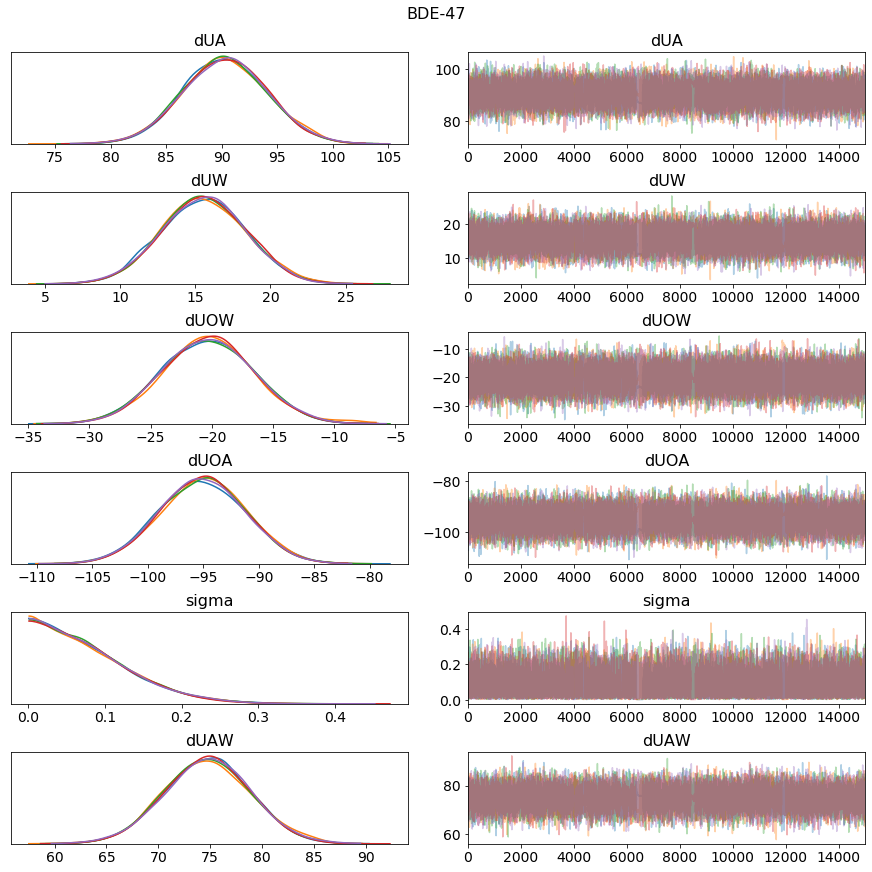

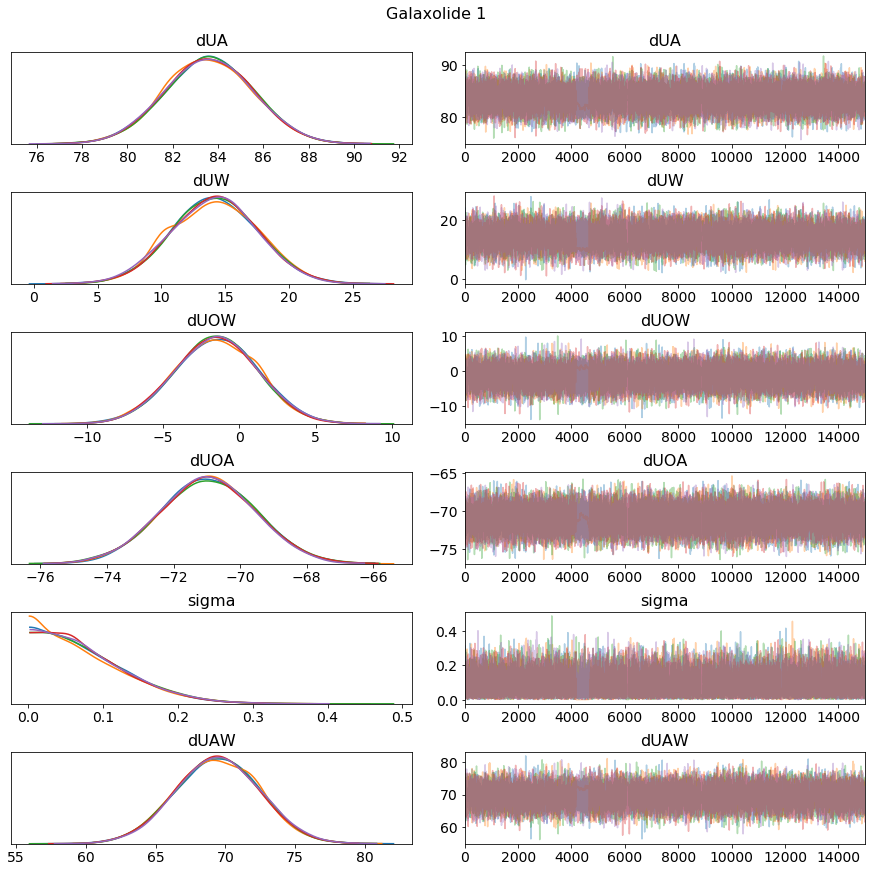

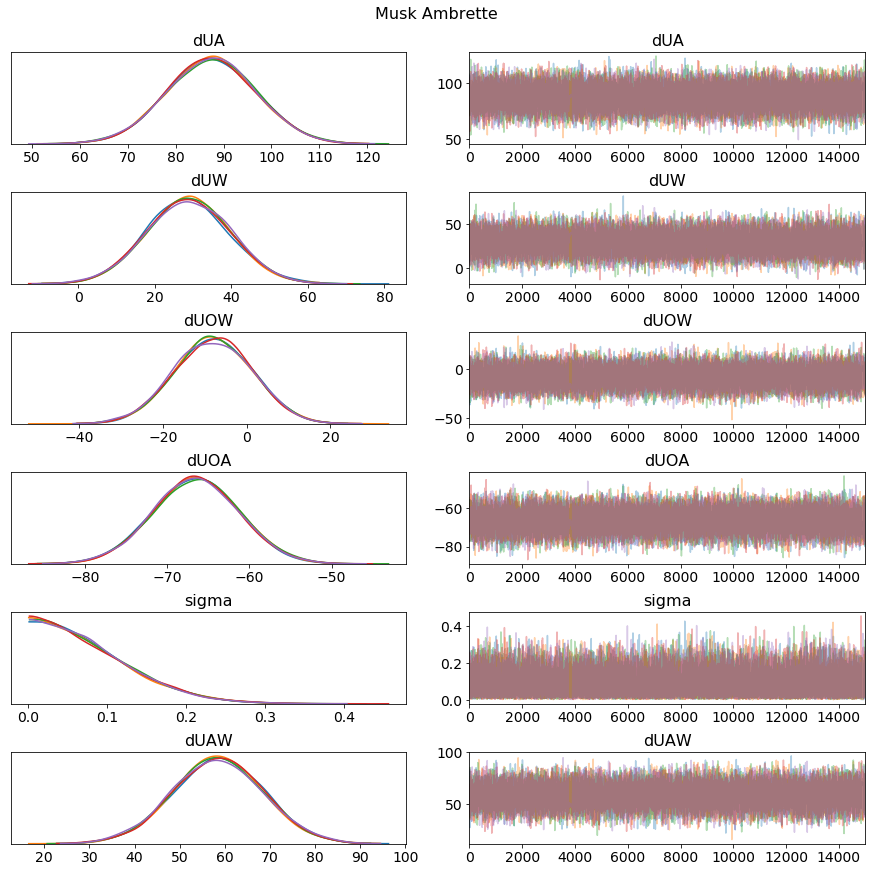

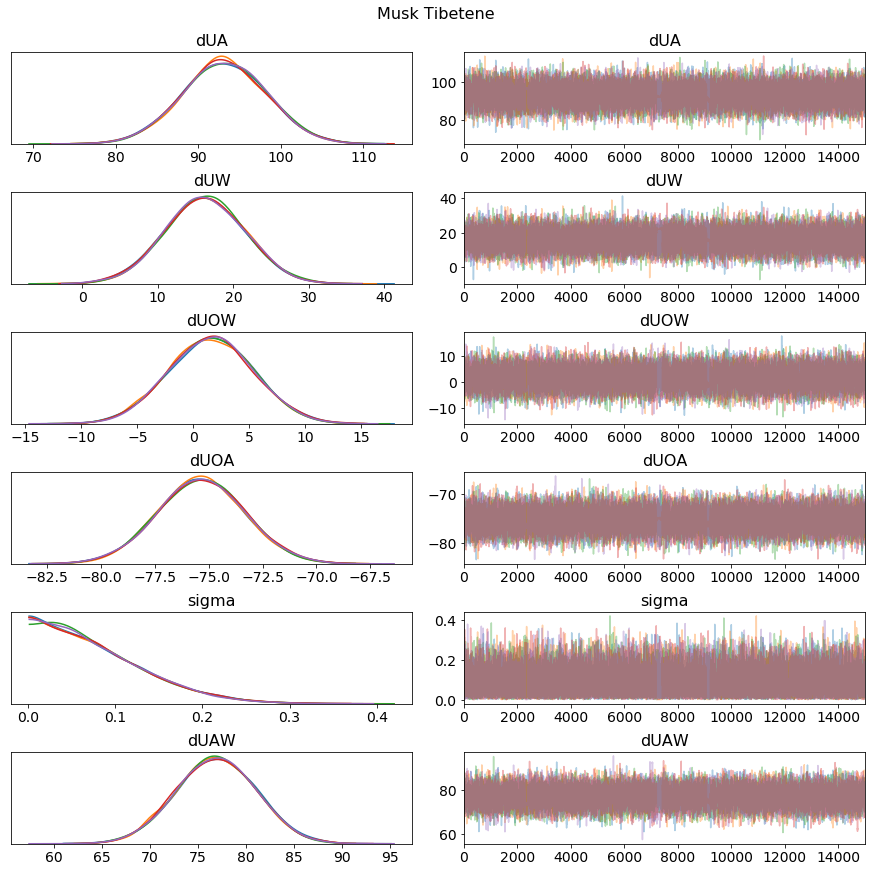

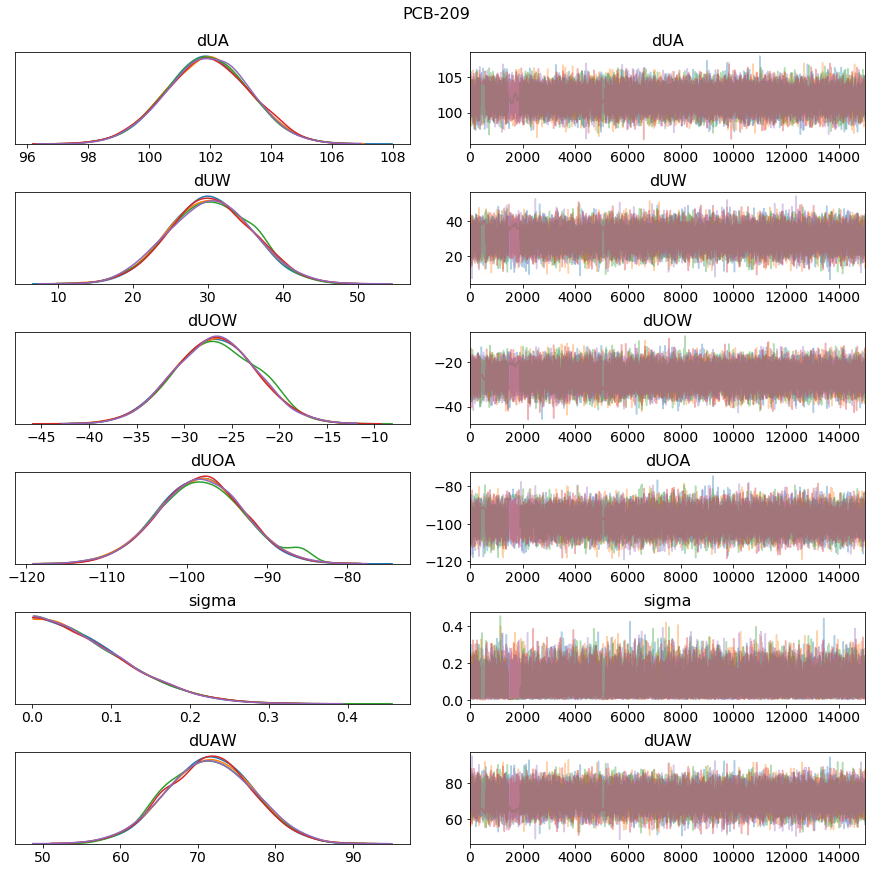

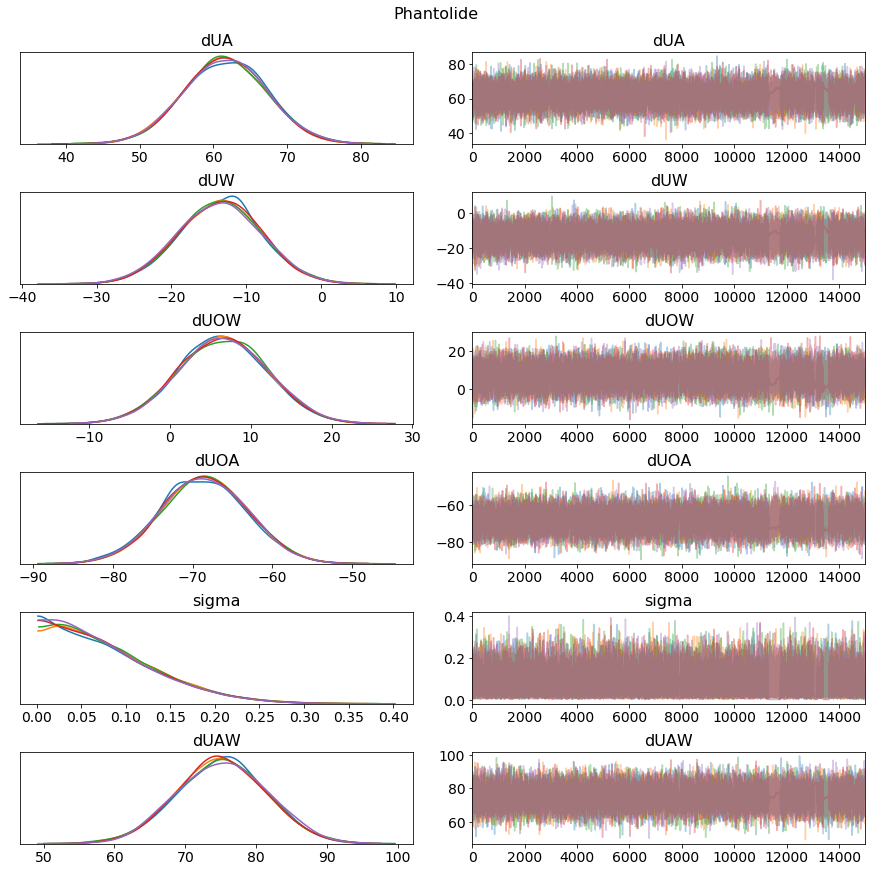

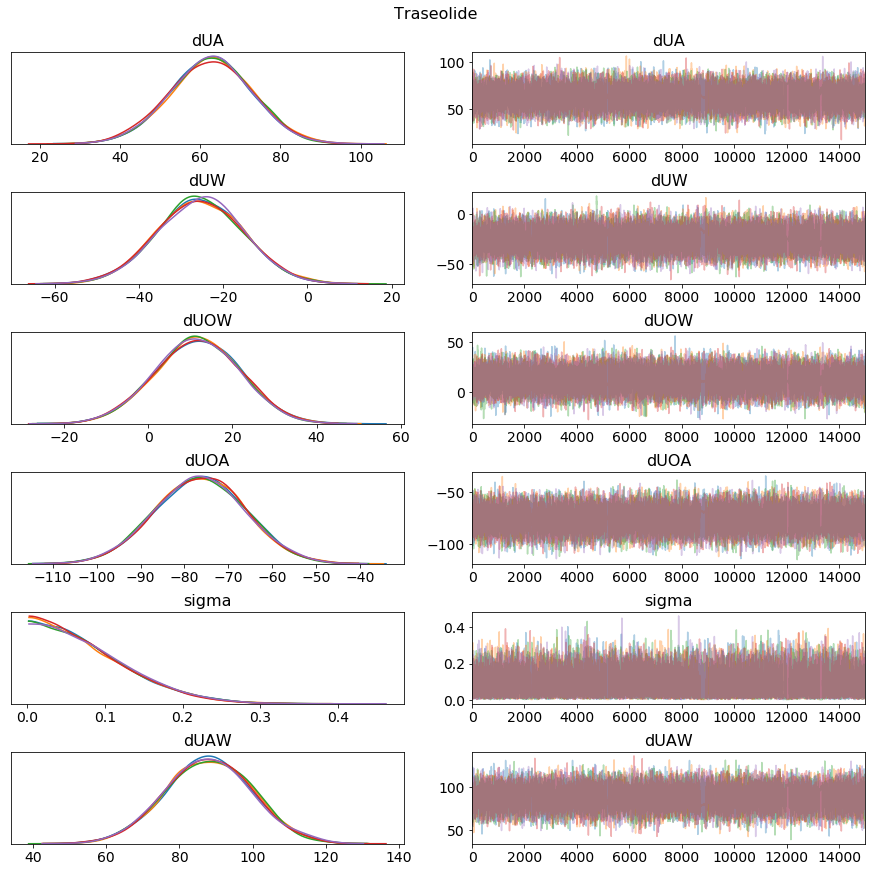

In [21]:
#Again, look at the trace plots and the number of effective samples to determine if the solution converged
#These first lines sets jupyter so that the traceplots and summary tables will all be displayed together
import os
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Define the directory where you have saved the traces.
directory = "Pickles/_FAV_Traces/dUs/4_param/"
#If you want to look at specific compoundd use the following two lines of code, otherwise it loops
#through the entire folder
#filenames = ['benzoapyrene_dUs_1125_1740']
#for filename in filenames:
#Loop through the folder
for filename in os.listdir(directory):
    #Define the compound from the filename, correct the square bracket error on the PAHs
    comp = filename[0:filename.find("_")]
    if comp == "benzokfluoranthene": #Error from the square brackets in loading files
        comp = "benzo[k]fluoranthene"
    elif comp == "benzoapyrene":
        comp = "benzo[a]pyrene"
    #Then, load the traceplot. You must have the correct model defined, unfortunately - so you need to
    #set-up the pymc3 model for each missing property.
    loaded5trace = pm.load_trace(directory = directory+filename, model = enth5_model);
    #The traceplot displays a graph of the poseteriors for each chain and the traceplots
    pm.traceplot(loaded5trace);
    #To give the figure a title need to obtain figure name and then define title
    fig = plt.gcf();
    fig.suptitle(comp, fontsize=16)
    #pm.summary displays 
    pm.summary(loaded5trace)
    #Put the finished FAVs into our output dataframe
    FAVs.loc[comp,'dUA'] = ufloat(loaded5trace['dUA'].mean(),loaded5trace['dUA'].std())
    FAVs.loc[comp,'dUW'] = ufloat(loaded5trace['dUW'].mean(),loaded5trace['dUW'].std())
    FAVs.loc[comp,'dUAW'] = ufloat(loaded5trace['dUAW'].mean(),loaded5trace['dUAW'].std())
    FAVs.loc[comp,'dUOW'] = ufloat(loaded5trace['dUOW'].mean(),loaded5trace['dUOW'].std())
    FAVs.loc[comp,'dUOA'] = ufloat(loaded5trace['dUOA'].mean(),loaded5trace['dUOA'].std())
#To assess this, as described in Rodgers et al (2020), look at ess_bulk - if it is >5,000, the system has
#almost certainly converged. If ess_bulk is <5,000, look at the figure - if the chains do not overlap
#you may need to rerun with a higher number of tuning steps or higher target_accept. For our tutorial it
#should work fine.

In [22]:
#Next, we will look at  p,p'-DDE and o,p'-DDT, which are missing dUo and dUaw. 
#Unfortunately, the only equation we can get for them is dUa-dUo+dUoa = 0, so we won't use the 
#literature value of dUw
numUs_absent = 2
uLDV.loc[uLDV.nUs_absent==numUs_absent,'dAU_absent':'dOAU_absent']
#There are quite a few this time. All except for p,p'-DDE and o,p'-DDT are missing the dUo and dUaw,
#those two are missing dUaw and dUow - we will deal with them later.

,dAU_absent,dWU_absent,dOU_absent,dAWU_absent,dOWU_absent,dOAU_absent
Compound Name,,,,,,
Musk Ambrette,False,False,True,True,False,False
Phantolide,False,False,True,True,False,False
Traseolide,False,False,True,True,False,False
Galaxolide 1,False,False,True,True,False,False
Musk Tibetene,False,False,True,True,False,False
"p,p'- DDE",False,False,False,True,True,False
"o,p'-DDT",False,False,False,True,True,False
BDE-47,False,False,True,True,False,False
PCB-209,False,False,True,True,False,False


In [25]:
#Now lets run the 3-parameter compounds
import pymc3 as pm
import arviz as az
from datetime import datetime
#3 Parameter Systems - there are more possibilites but in our dataset only dUa-dUo+dUoa = 0 is present
numUs_absent = 2
mask = (uLDV.nUs_absent>=numUs_absent)&(uLDV.dAU_absent==False)&(uLDV.dOU_absent==False)&(uLDV.dOAU_absent==False)
comps = uLDV[mask].index
#comps = ["o,p'-DDT","p,p'- DDE"]#These two are the only ones 
enthbasemat = np.array([1, -1, 1])  #dUa-dUo+dUoa
X = enthbasemat
y = 0
#Then, we set up our Bayesian model with the measurements as priors for the model regression parameters. 
for comp in comps:
    #Now we will define the misclosure error, and use that as our baseline minimum error for the system
    w3 = (uLDV.loc[comp,'dAU'] - uLDV.loc[comp,'dOU']+ uLDV.loc[comp,'dOAU']).n
    enth3_model = pm.Model()
    beta = [0,0,0]
    base_sd = abs(w3/3)
    with enth3_model:
        #Define priors
        sigma = pm.HalfNormal('sigma', 0.1, testval=0.1)
        #For the phys-chem properties, we have some choices of priors depending on our confidence in the data.
        #For our defaults we can use normal distributions.
        #pdb.set_trace()
        #dUa-dUo+dUoa
        beta[0] = pm.Normal('dUA', mu = uLDV.loc[comp,'dAU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dVAPH_NumVals'],uLDV.loc[comp,'dAU'].s))
        beta[1] = pm.Normal('dUO', mu = uLDV.loc[comp,'dOU'].n,\
                            sigma=max(base_sd/uLDV.loc[comp,'dOU_NumVals'],uLDV.loc[comp,'dOU'].s))        
        beta[2] = pm.Normal('dUOA', mu = uLDV.loc[comp,'dOAU'].n,\
                           sigma=max(base_sd/uLDV.loc[comp,'dOAU_NumVals'],uLDV.loc[comp,'dOAU'].s))

        epsilon = np.dot(X,beta) #This gives us the misclosure error for each of the three equations
        #The model tries to fit to an observation, in this case that the misclosure should be 0.
        #Here we are going to use the sum of squared errors, as in multi-equation systems this prevents
        #optimization of only one of the equations.
        mu = epsilon**2
        #Likelihood (sampling distribution) of observations
        #Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)#Normal
        Y_obs = pm.StudentT('Y_obs',nu = len(beta)-1, mu=mu, sigma=sigma, observed=y)#Students for robust regression (broader tails)
        '''
        enth3_trace = pm.sample(10000, tune=10000,chains = 5, cores = 10, target_accept = 0.90,max_treedepth = 15)
        #pdb.set_trace()
        if comp == "benzo[k]fluoranthene": #Error from the square brackets in loading files
            comp = "benzokfluoranthene"
        elif comp == "benzo[a]pyrene":
            comp = "benzoapyrene"
        savename = str('Pickles/'+ comp+"_dUs_"+datetime.now().strftime("%m%d_%H%M"))
        pm.save_trace(enth3_trace,directory = savename,overwrite=True)
        '''

'\n        enth3_trace = pm.sample(10000, tune=10000,chains = 5, cores = 10, target_accept = 0.90,max_treedepth = 15)\n        #pdb.set_trace()\n        if comp == "benzo[k]fluoranthene": #Error from the square brackets in loading files\n            comp = "benzokfluoranthene"\n        elif comp == "benzo[a]pyrene":\n            comp = "benzoapyrene"\n        savename = str(\'Pickles/\'+ comp+"_dUs_"+datetime.now().strftime("%m%d_%H%M"))\n        pm.save_trace(enth3_trace,directory = savename,overwrite=True)\n        '

'\n        enth3_trace = pm.sample(10000, tune=10000,chains = 5, cores = 10, target_accept = 0.90,max_treedepth = 15)\n        #pdb.set_trace()\n        if comp == "benzo[k]fluoranthene": #Error from the square brackets in loading files\n            comp = "benzokfluoranthene"\n        elif comp == "benzo[a]pyrene":\n            comp = "benzoapyrene"\n        savename = str(\'Pickles/\'+ comp+"_dUs_"+datetime.now().strftime("%m%d_%H%M"))\n        pm.save_trace(enth3_trace,directory = savename,overwrite=True)\n        '

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000193A9130B70>,
      dtype=object)

Text(0.5, 0.98, "o,p'-DDT")

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dUA,86.442,1.099,84.387,88.501,0.008,0.006,17605.0,17592.0,17634.0,20513.0,1.0
dUO,2.445,0.973,0.641,4.283,0.007,0.005,17555.0,17555.0,17535.0,17153.0,1.0
dUOA,-84.018,0.785,-85.496,-82.543,0.005,0.004,22945.0,22945.0,22947.0,29058.0,1.0
sigma,0.048,0.052,0.000,0.148,0.000,0.000,19276.0,19276.0,5124.0,2092.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001939FC5F390>,
      dtype=object)

Text(0.5, 0.98, "p,p'- DDE")

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
dUA,79.436,2.299,75.058,83.710,0.014,0.01,27268.0,27268.0,27352.0,29325.0,1.0
dUO,-5.314,2.380,-9.872,-0.919,0.014,0.01,29203.0,29049.0,29151.0,34252.0,1.0
dUOA,-84.739,2.354,-89.098,-80.276,0.014,0.01,28699.0,28648.0,28730.0,31155.0,1.0
sigma,0.048,0.052,0.000,0.147,0.000,0.00,22049.0,22049.0,4359.0,1553.0,1.0


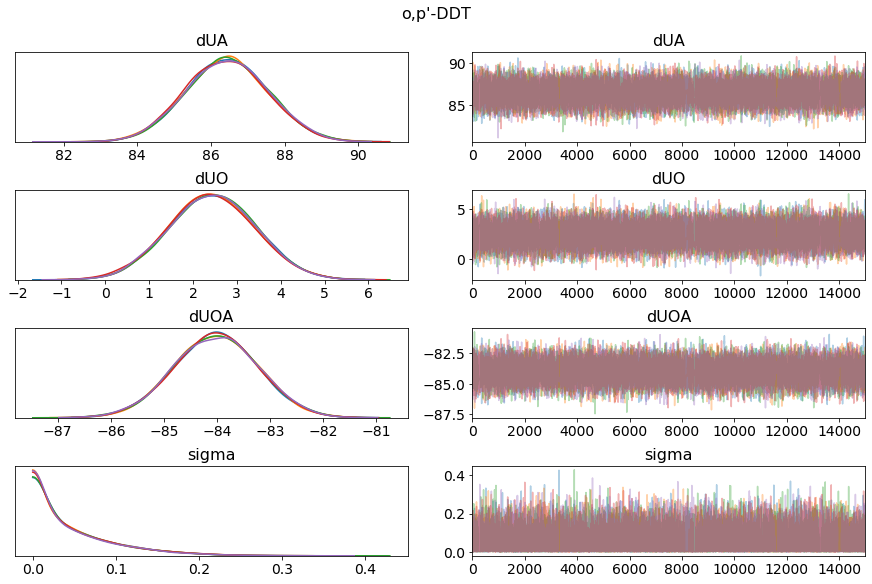

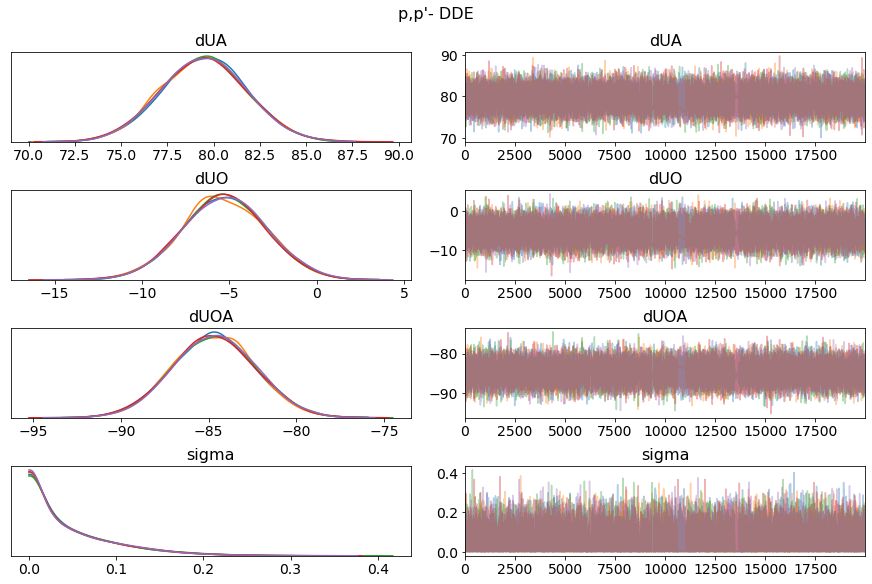

In [26]:
#Again, look at the trace plots and the number of effective samples to determine if the solution converged
#These first lines sets jupyter so that the traceplots and summary tables will all be displayed together
import os
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Define the directory where you have saved the traces.
directory = "Pickles/_FAV_Traces/dUs/3_param/"
#If you want to look at specific compoundd use the following two lines of code, otherwise it loops
#through the entire folder
#filenames = ['benzoapyrene_dUs_1125_1740']
#for filename in filenames:
#Loop through the folder
for filename in os.listdir(directory):
    #Define the compound from the filename, correct the square bracket error on the PAHs
    comp = filename[0:filename.find("_")]
    if comp == "benzokfluoranthene": #Error from the square brackets in loading files
        comp = "benzo[k]fluoranthene"
    elif comp == "benzoapyrene":
        comp = "benzo[a]pyrene"
    #Then, load the traceplot. You must have the correct model defined, unfortunately - so you need to
    #set-up the pymc3 model for each missing property.
    loaded3trace = pm.load_trace(directory = directory+filename, model = enth3_model);
    #The traceplot displays a graph of the poseteriors for each chain and the traceplots
    pm.traceplot(loaded3trace);
    #To give the figure a title need to obtain figure name and then define title
    fig = plt.gcf();
    fig.suptitle(comp, fontsize=16)
    #pm.summary displays 
    pm.summary(loaded3trace)
    #Put the finished FAVs into our output dataframe
    FAVs.loc[comp,'dUA'] = ufloat(loaded3trace['dUA'].mean(),loaded3trace['dUA'].std())
    FAVs.loc[comp,'dUW'] = ufloat(loaded3trace['dUO'].mean(),loaded3trace['dUO'].std())
    FAVs.loc[comp,'dUOA'] = ufloat(loaded3trace['dUOA'].mean(),loaded3trace['dUOA'].std())
#To assess this, as described in Rodgers et al (2020), look at ess_bulk - if it is >5,000, the system has
#almost certainly converged. If ess_bulk is <5,000, look at the figure - if the chains do not overlap
#you may need to rerun with a higher number of tuning steps or higher target_accept. For our tutorial it
#should work fine.

In [27]:
#Unfortunately, that is all we can do with internal energies as we can't get a consistent system for any
#of the other compounds. But not to fear - we will supplement this dataset with in silico estimations
#and come back to make recommended FAVs (FAVRs)!
numUs_absent = 3
uLDV.loc[uLDV.nUs_absent==numUs_absent,'dAU_absent':'dOAU_absent']

,dAU_absent,dWU_absent,dOU_absent,dAWU_absent,dOWU_absent,dOAU_absent
Compound Name,,,,,,
Celestolide,True,False,True,True,False,False
Moskene,False,True,True,True,False,False
Tonalide,True,False,True,True,False,False
"o,p'-DDD",False,False,True,True,True,False
"p,p'-DDD",False,False,True,True,True,False
aldrin,False,False,True,True,True,False
BDE-99,False,False,True,True,True,False
PCB-19,False,False,True,True,True,False
PCB-119,False,False,True,True,True,False


In [28]:
#Then, make sure you load everything into the FAV file and we will look at the misclosure error and 
#adjustments
#Without IGS compounds: p,p'-DDE, o,p'-DDT, BaP, BDE-47, Galaxolide 1, Ambrette, Tibetine, PCB-209, phantolide, traseolide
comps = ['benzo[a]pyrene',"p,p'- DDE",'BDE-47','Musk Ambrette', 'Phantolide', 'Traseolide', 'Galaxolide 1', 'Musk Tibetene',\
         'PCB-209',"o,p'-DDT"]
FAVs.loc[:,'e_dUA'] = uLDV.loc[:,'dAU']-FAVs.loc[:,'dUA'] 
FAVs.loc[:,'e_dUW'] = uLDV.loc[:,'dWU']-FAVs.loc[:,'dUW']
FAVs.loc[:,'e_dUO'] = uLDV.loc[:,'dOU']-FAVs.loc[:,'dUO']
FAVs.loc[:,'e_dUAW'] = uLDV.loc[:,'dAWU']-FAVs.loc[:,'dUAW']
FAVs.loc[:,'e_dUOW'] = uLDV.loc[:,'dOWU']-FAVs.loc[:,'dUOW'] 
FAVs.loc[:,'e_dUOA'] = uLDV.loc[:,'dOAU']-FAVs.loc[:,'dUOA'] 
#LDV.loc[['BDE-47','BDE-99'],['dAU','dWU','dAWU','dOWU','dOAU']]
FAVs.loc[comps,['e_dUA','e_dUW','e_dUO','e_dUAW','e_dUOW','e_dUOA']]
FAVs.loc[comps,'dUA':'dUOA']

,e_dUA,e_dUW,e_dUO,e_dUAW,e_dUOW,e_dUOA
Compound Name,,,,,,
benzo[a]pyrene,-7+/-9,-3+/-10,1.0+/-3.4,nan+/-5.1063942085399505,-1+/-7,-1+/-4
"p,p'- DDE",3+/-4,38+/-7,-8.4+/-1.7,nan+/-0,nan+/-0,3+/-4
BDE-47,1+/-6,-1+/-4,nan+/-0,nan+/-4.100390430751103,-1+/-6,2+/-6
Musk Ambrette,-10+/-11,19+/-18,nan+/-0,nan+/-9.904536230820627,10+/-9,-3+/-6
Phantolide,6+/-7,-6+/-8,nan+/-0,nan+/-6.289197522109968,-7+/-6,6+/-8
Traseolide,12+/-12,-12+/-15,nan+/-0,nan+/-11.765311113688178,-12+/-10,12+/-11
Galaxolide 1,-0.7+/-2.8,9+/-8,nan+/-0,nan+/-2.977612632964968,1.6+/-2.7,-0.4+/-1.4
Musk Tibetene,-6+/-8,7+/-9,nan+/-0,nan+/-4.104016155514943,2+/-4,-0.6+/-2.7
PCB-209,-0.3+/-1.5,7+/-9,nan+/-0,nan+/-5.574918676861081,3+/-6,-6+/-8


,dUA,dUW,dUO,dUAW,dUOW,dUOA
Compound Name,,,,,,
benzo[a]pyrene,107.2+/-3.4,31+/-5,6.6+/-2.6,76+/-5,-25+/-4,-100.6+/-2.5
"p,p'- DDE",79.4+/-2.3,-5.3+/-2.4,0.0+/-0,0.0+/-0,0.0+/-0,-84.7+/-2.4
BDE-47,90+/-4,15.6+/-2.8,0.0+/-0,75+/-4,-20+/-4,-95+/-4
Musk Ambrette,87+/-9,29+/-11,0.0+/-0,59+/-10,-8+/-9,-66+/-5
Phantolide,62+/-6,-13+/-5,0.0+/-0,75+/-6,7+/-6,-69+/-5
Traseolide,63+/-10,-25+/-10,0.0+/-0,88+/-12,12+/-10,-76+/-10
Galaxolide 1,83.6+/-1.9,14.2+/-3.4,0.0+/-0,69.4+/-3.0,-1.5+/-2.7,-71.0+/-1.4
Musk Tibetene,93+/-5,16+/-5,0.0+/-0,77+/-4,2+/-4,-75.3+/-2.0
PCB-209,101.9+/-1.4,30+/-6,0.0+/-0,72+/-6,-27+/-4,-98+/-5


In [30]:
#Then, export to a CSV for the next step
#pdb.set_trace()
FAVs_exp = pd.DataFrame(index = FAVs.index)
FAVs_exp.loc[:,'dUA'] = unumpy.nominal_values(FAVs.loc[:,'dUA'])
FAVs_exp.loc[:,'dUA_SD'] = unumpy.std_devs(FAVs.loc[:,'dUA'])
FAVs_exp.loc[:,'dUW'] = unumpy.nominal_values(FAVs.loc[:,'dUW'])
FAVs_exp.loc[:,'dUW_SD'] = unumpy.std_devs(FAVs.loc[:,'dUW'])
FAVs_exp.loc[:,'dUO'] = unumpy.nominal_values(FAVs.loc[:,'dUO'])
FAVs_exp.loc[:,'dUO_SD'] = unumpy.std_devs(FAVs.loc[:,'dUO'])
FAVs_exp.loc[:,'dUAW'] = unumpy.nominal_values(FAVs.loc[:,'dUAW'])
FAVs_exp.loc[:,'dUAW_SD'] = unumpy.std_devs(FAVs.loc[:,'dUAW'])
FAVs_exp.loc[:,'dUOW'] = unumpy.nominal_values(FAVs.loc[:,'dUOW'])
FAVs_exp.loc[:,'dUOW_SD'] = unumpy.std_devs(FAVs.loc[:,'dUOW'])
FAVs_exp.loc[:,'dUOA'] = unumpy.nominal_values(FAVs.loc[:,'dUOA'])
FAVs_exp.loc[:,'dUOA_SD']= unumpy.std_devs(FAVs.loc[:,'dUOA'])

#Need to define a filepath - choose wherever you like, here you can see my file set up for GitHub
filepath = "D:/Users/Tim Rodgers/Documents/GitHub/FAVs_Paper/"
FAVs_exp.to_csv(filepath+"FAVLs_dUs.csv")

Now (in a different application), pick your favourite in silico estimations and construct a set of 
internal energy values without any missing properties. For Rodgers et al. (2020), we did not have a reliable
in silico estimation of dUo, so we constructed a set of values that was missing only dUo. We will assume that is the case for this tutorial.

Using these values, we are going to make a full set of recommended FAVs (FAVRs). If you are following along
with Rodgers et al, 2020, the input file is called "LDVMDV_Data.xlsx"

In [35]:
#Same as before, load data and process. This time we are using a dataset that also includes in silico values,
#I have called this the "combined derived values" (CDVs) in this workbook.
import pandas as pd
import numpy as np
import math
import pymc3 as pm
import uncertainties
from uncertainties import ufloat
from uncertainties import unumpy
import pdb
CDV = pd.read_excel('LDVMDV_Data.xlsx', index_col = 2)
#Now, we are going to make each of our CDVs into uncertain variables with the uncertaintites through this package.
#We will make a separate dataframe for the uncertain values
startcol = 3 #First column with CDVs in it. Column order should have all data identifiers first, followed by CDVs
#and their standard deviations in pairs
uCDV = pd.DataFrame(index = CDV.index)
colnames =['dVAPH','dWU','dOU','dOAU','dAWU','dOWU','LogKOA','LogKOW','LogKAW','LogPL','LogSW','LogSO','dfusS','Tm']
i = 0
#pdb.set_trace()
for idx,cols in enumerate(CDV.columns[startcol:]):
    #pdb.set_trace()
    if idx/3 != math.ceil(idx/3): #Skip every third column, which have the standard deviations & number of lit values
        pass
    else:
        #print(idx)
        colname = colnames[i]
        uCDV.loc[:,colname] = unumpy.uarray(CDV.loc[:,cols],CDV.iloc[:,idx+startcol+1])#adding 5 to get to first SD value
        #pdb.set_trace()
        i+=1
#Run again for the number of columns, we will put this at the end as I added this later
i = 0
for idx,cols in enumerate(CDV.columns[startcol:]):
    #pdb.set_trace()
    if idx/3 != math.ceil(idx/3): #Skip every third column, which have the standard deviations & number of lit values
        pass
    else:
        #print(idx)
        colname = colnames[i]+str('_NumVals')
        uCDV.loc[:,colname] = CDV.iloc[:,idx+startcol+2] #Column where number of values is stored
        #The number of literature values is used to weight the prior standard distribution to reflect our 
        #confidence in the literature-derived values. As a minimum, we are setting our standard deviation
        #equal to the "naive" adjustment you would make if you adjusted all properties equally divided by
        #the number of lit values for that property. This next line allows us to weight modeled values 
        #lower than a measured value - for instance, if this is 1/2 we would have twice the uncertainty on
        #a modeled parameter as on a measured parameter, if their input SDs were lower than that value.
        uCDV.loc[uCDV.loc[:,colname]==0,colname] = 0.5 #Weight modeled values as 1/2 a single measured value
        #pdb.set_trace()
        i+=1
#Then, lets convert our vapour pressure to a solubility as Sa = VP/RT
R = 8.314 #J/molK
T = 298.15 #K
uCDV.loc[:,'LogSA'] = unumpy.log10(10**(uCDV.LogPL)/(R*T))#Convert to mol/m³
uCDV.loc[uCDV.LogPL==0,'LogSA'] = np.nan #Convert zeros to nan\
#Here we will also convert the wet octanol partition coefficient to dry so that we are all on the same page
#Using the relationships from Beyer (2002)
CDV.loc[:,'LogKOWd'] = np.nan#initialize
mask = uCDV.loc[:,'LogKOW']<=4
uCDV.loc[mask,'LogKOWd'] = uCDV.LogKOW - 0.117 #If Kow<=4
uCDV.loc[mask==False,'LogKOWd'] = 1.35*uCDV.LogKOW - 1.58
uCDV.loc[uCDV.LogKOW==0,'LogKOWd'] = np.nan #Convert zeros to nan\
#convert to internal energy of phase change (dU) rather than enthalpies (dH) (see Goss 1996 DOI 10.1021/es950508f) using rel.
#found by Beyer et al. (2002) for PCBs, namely dAU = dvapH - 2,391 J/mol. Like Beyer, we will assume that all enthalpies of
#phase change in the water phase are actually internal energies, as they were measured volumetrically.
uCDV.loc[:,'dAU'] = uCDV.dVAPH - 2391/1000
uCDV.loc[uCDV.dVAPH==0,'dAU'] = np.nan #Convert zeros to nan\
uCDV = uCDV.replace(0,np.nan) #Convert all zeros to nans for the next part
#uCDV
#Now. lets make the dataframe where we will store our FAVRs once they have been estimated! 
FAVRs = pd.DataFrame(index = uCDV.index)
FAVRs.loc[:,'dUA']=unumpy.uarray(0,0) #Need to initialize with a value or it doesn't like the ufloat objects
FAVRs.loc[:,'dUW'] = unumpy.uarray(0,0)
FAVRs.loc[:,'dUO'] = unumpy.uarray(0,0)
FAVRs.loc[:,'dUAW']= unumpy.uarray(0,0)
FAVRs.loc[:,'dUOW']= unumpy.uarray(0,0)
FAVRs.loc[:,'dUOA']= unumpy.uarray(0,0)
#And, define the misclosure error for the 5 parameter system (missing dUo)
uCDV.loc[:,'w5_1'] = (uCDV.loc[:,'dAU'] - uCDV.loc[:,'dWU'] - uCDV.loc[:,'dAWU'])
uCDV.loc[:,'w5_2'] = (uCDV.loc[:,'dAWU'] - uCDV.loc[:,'dOWU'] + uCDV.loc[:,'dOAU'])

In [37]:
#Let's first check to make sure that all of the enthalpy values are present - since we are combining the
#measured and modeled values there shouldn't be any missing (other than dUo, which we won't count)
propsabsent = unumpy.isnan([uCDV.loc[:,'dAU'],uCDV.loc[:,'dWU']\
            ,uCDV.loc[:,'dAWU'],\
            uCDV.loc[:,'dOWU'],uCDV.loc[:,'dOAU']]).T
propsabsent.sum()

0

In [39]:
#Five Parameters using CDVs. Note that this can take quite a long time to converge - up to several hours
#per compound depending on the parameterization.
#dUa*(1)+ dUw *(-1) + dUAW *(-1)= 0 [1 -1 -1 0 0] = 0
#dUAW*(1)+ dUOW *(-1) + dUOA *(1)= 0 [0 0 1 -1 1] = 0
import pymc3 as pm
import arviz as az
from datetime import datetime
comps = uCDV.index
#comps = ['PCB-209']
enthbasemat = np.array([[1, -1, -1, 0, 0],[0, 0, 1, -1, 1]])  #Order is: dUa, dUw, dUaw, dUow, dUoa
X = enthbasemat
y = 0
base_sd = 0 #initialize
enth5_model = pm.Model()
beta = [0,0,0,0,0]
for comp in comps:
    #Initialize the model inside the loop for each compound
    enth5_model = pm.Model()
    #For these compounds, set the base SD the same as for the algebraic equation
    base_sd = max(abs(uCDV.loc[comp,'w5_1']),abs(uCDV.loc[comp,'w5_2'])).n/3
    with enth5_model:
        #Define priors
        #Prior on the misclosure error - small so that the system will find FAVs
        sigma = pm.HalfNormal('sigma', 0.1, testval=0.1)
        beta[0] = pm.Normal('dUA', mu = uCDV.loc[comp,'dAU'].n,\
                            sigma=max(base_sd/uCDV.loc[comp,'dVAPH_NumVals'],uCDV.loc[comp,'dAU'].s))
        beta[1] = pm.Normal('dUW', mu = uCDV.loc[comp,'dWU'].n,\
                            sigma=max(base_sd/uCDV.loc[comp,'dWU_NumVals'],uCDV.loc[comp,'dWU'].s))
        beta[2] = pm.Normal('dUAW', mu = uCDV.loc[comp,'dAWU'].n,\
                            sigma=max(base_sd/uCDV.loc[comp,'dAWU_NumVals'],uCDV.loc[comp,'dAWU'].s))
        beta[3] = pm.Normal('dUOW', mu = uCDV.loc[comp,'dOWU'].n,\
                            sigma=max(base_sd/uCDV.loc[comp,'dOWU_NumVals'],uCDV.loc[comp,'dOWU'].s))
        beta[4] = pm.Normal('dUOA', mu = uCDV.loc[comp,'dOAU'].n,\
                            sigma=max(base_sd/uCDV.loc[comp,'dOAU_NumVals'],uCDV.loc[comp,'dOAU'].s))
        #next, we calculate the misclosure closure error for each of the equations
        epsilon = np.dot(X,beta) #This gives us the misclosure error for each of the equations
        #The model tries to fit to an observation, in this case that the misclosure should be 0.
        #Here we are going to use the sum of squared errors, so that we don't get one big error and one small one
        mu = np.sum(epsilon**2)
        #Likelihood (sampling distribution) of observations - the probability that we will
        #see the outputs given the inputs & the model parameters. MCMC maximizes this likelihood
        Y_obs = pm.StudentT('Y_obs',nu = 3, mu=mu, sigma=sigma, observed=y)#Students for robust regression (broader tails)
        #Run the model
        '''
        enth5_trace = pm.sample(10000, tune=10000,chains = 5, cores = 10,target_accept = 0.90,max_treedepth=15)
        #pdb.set_trace()
        #Put the finished PAVs into our output dataframe!
        PAVs.loc[comp,'dUA'] = ufloat(enth5_trace['dUA'].mean(),enth5_trace['dUA'].std())
        PAVs.loc[comp,'dUW'] = ufloat(enth5_trace['dUW'].mean(),enth5_trace['dUW'].std())
        PAVs.loc[comp,'dUAW'] = ufloat(enth5_trace['dUAW'].mean(),enth5_trace['dUAW'].std())
        PAVs.loc[comp,'dUOW'] = ufloat(enth5_trace['dUOW'].mean(),enth5_trace['dUOW'].std())
        PAVs.loc[comp,'dUOA'] = ufloat(enth5_trace['dUOA'].mean(),enth5_trace['dUOA'].std())
        #Save the resulting trace
        if comp == "benzo[k]fluoranthene": #Error from the square brackets in loading files
            comp = "benzokfluoranthene"
        elif comp == "benzo[a]pyrene":
            comp = "benzoapyrene"
        savename = str('Pickles/'+ comp+"_dUs_"+datetime.now().strftime("%m%d_%H%M"))
        pm.save_trace(enth5_trace,directory = savename,overwrite=True)
        '''

'\n        enth5_trace = pm.sample(10000, tune=10000,chains = 5, cores = 10,target_accept = 0.90,max_treedepth=15)\n        #pdb.set_trace()\n        #Put the finished PAVs into our output dataframe!\n        PAVs.loc[comp,\'dUA\'] = ufloat(enth5_trace[\'dUA\'].mean(),enth5_trace[\'dUA\'].std())\n        PAVs.loc[comp,\'dUW\'] = ufloat(enth5_trace[\'dUW\'].mean(),enth5_trace[\'dUW\'].std())\n        PAVs.loc[comp,\'dUAW\'] = ufloat(enth5_trace[\'dUAW\'].mean(),enth5_trace[\'dUAW\'].std())\n        PAVs.loc[comp,\'dUOW\'] = ufloat(enth5_trace[\'dUOW\'].mean(),enth5_trace[\'dUOW\'].std())\n        PAVs.loc[comp,\'dUOA\'] = ufloat(enth5_trace[\'dUOA\'].mean(),enth5_trace[\'dUOA\'].std())\n        #Save the resulting trace\n        if comp == "benzo[k]fluoranthene": #Error from the square brackets in loading files\n            comp = "benzokfluoranthene"\n        elif comp == "benzo[a]pyrene":\n            comp = "benzoapyrene"\n        savename = str(\'Pickles/\'+ comp+"_dUs_"+datetime.no

In [ ]:
#Then, load the different compounds and look at the traceplots. Use caution here - opening a lot of plots 
#can crash your computer
import os
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#comps = uCDV[uCDV.index!='BDE-47'].index
directory = "Pickles/_FAVRs/"
for filename in os.listdir(directory): #use for going through entire folder
#for filename in filenames: #Go through a list of files
    comp = filename[0:filename.find("_")]
    if comp == "benzokfluoranthene": #Error from the square brackets in loading files
        comp = "benzo[k]fluoranthene"
    elif comp == "benzoapyrene":
        comp = "benzo[a]pyrene"
        
    loaded5trace = pm.load_trace(directory = directory+filename, model = enth5_model);
    pm.traceplot(loaded5trace);
    fig = plt.gcf();
    fig.suptitle(comp, fontsize=16)
    pm.summary(loaded5trace)

In [ ]:
#Now, we export the FAVRs to 
PAVs_exp = pd.DataFrame(index = PAVs.index)
PAVs_exp.loc[:,'dUA'] = unumpy.nominal_values(PAVs.loc[:,'dUA'])
PAVs_exp.loc[:,'dUA_SD'] = unumpy.std_devs(PAVs.loc[:,'dUA'])
PAVs_exp.loc[:,'dUW'] = unumpy.nominal_values(PAVs.loc[:,'dUW'])
PAVs_exp.loc[:,'dUW_SD'] = unumpy.std_devs(PAVs.loc[:,'dUW'])
PAVs_exp.loc[:,'dUAW'] = unumpy.nominal_values(PAVs.loc[:,'dUAW'])
PAVs_exp.loc[:,'dUAW_SD'] = unumpy.std_devs(PAVs.loc[:,'dUAW'])
PAVs_exp.loc[:,'dUOW'] = unumpy.nominal_values(PAVs.loc[:,'dUOW'])
PAVs_exp.loc[:,'dUOW_SD'] = unumpy.std_devs(PAVs.loc[:,'dUOW'])
PAVs_exp.loc[:,'dUOA'] = unumpy.nominal_values(PAVs.loc[:,'dUOA'])
PAVs_exp.loc[:,'dUOA_SD']= unumpy.std_devs(PAVs.loc[:,'dUOA'])

#Need to define a filepath - choose wherever you like, here you can see my file set up for GitHub
filepath = "D:/Users/Tim Rodgers/Documents/GitHub/FAVs_Paper/"
FAVs_exp.to_csv(filepath+"FAVRs_dUs.csv")
#PAVs_exp.to_csv("D:/Users/Tim Rodgers/Documents/GitHub/FAVs_Paper/PAVs_noIGS.csv")

Finally, we are done with the internal energies! Next we will do the partition coefficients and solubilities
in a separate Jupyter notebook, for convenience. You can use the FAVRs generated here for the internal
energies to temperature-correct any literature values you may have found not at 25°C for the partition 
coefficients and solubilities.